# **CSE475 Sec03 Group5 YOLO Comparison**
**Course:** CSE 475 - Machine Learning Section: 03

**Assignment:** Object Detection and Model Comparison using YOLOv10, YOLOv11, and YOLOv12

**Dataset:** SylFishBD: A Freshwater Fish Dataset

**Group Members:**


1. Md. Shahariar Rahman Rafi - 2022-1-60-176

2. Mahin Hasan - 2022-1-60-180

3. Meheran Jahedi Evan - 2022-1-60-025


# Dataset Setup

In [1]:
!pip install ultralytics --no-deps

import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil
import json
import yaml
import cv2
import random
import matplotlib.pyplot as plt
from IPython.display import Image, display
import torch
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Data Preparation

In [2]:
INPUT_PATH = '/kaggle/input/sylfishbd/sylfishbd'
OUTPUT_PATH = '/kaggle/working/SylFishBD-YOLO'
IMG_WIDTH = 500
IMG_HEIGHT = 500

os.makedirs(os.path.join(OUTPUT_PATH, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'images/test'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'labels/val'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'labels/test'), exist_ok=True)

metadata_path = os.path.join(INPUT_PATH, 'metadata.csv')
df = pd.read_csv(metadata_path)
class_names = sorted(df['class_name'].unique())
class_map = {name: i for i, name in enumerate(class_names)}
print("\nClass mapping created:")
print(class_map)

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['class_name'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['class_name'])
print(f"\nDataset split complete:")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

def process_data(dataframe, split_name):
    print(f"\nProcessing '{split_name}' split...")
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        json_source_path = os.path.join(INPUT_PATH, row['annotation_path'])
        
        with open(json_source_path, 'r') as f:
            data = json.load(f)

        points = data['shapes'][0]['points']
        x_min, y_min = points[0]
        x_max, y_max = points[1]

        img_source_path = os.path.join(INPUT_PATH, row['image_path'])
        base_filename = os.path.splitext(os.path.basename(row['image_path']))[0]
        img_dest_path = os.path.join(OUTPUT_PATH, f'images/{split_name}/{base_filename}.jpg')
        label_dest_path = os.path.join(OUTPUT_PATH, f'labels/{split_name}/{base_filename}.txt')
        class_name = row['class_name']
        class_index = class_map[class_name]
        
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        x_center = x_min + (bbox_width / 2)
        y_center = y_min + (bbox_height / 2)
        
        x_center_norm = x_center / IMG_WIDTH
        y_center_norm = y_center / IMG_HEIGHT
        width_norm = bbox_width / IMG_WIDTH
        height_norm = bbox_height / IMG_HEIGHT
        
        with open(label_dest_path, 'w') as f:
            f.write(f"{class_index} {x_center_norm} {y_center_norm} {width_norm} {height_norm}\n")
        
        shutil.copy(img_source_path, img_dest_path)

process_data(train_df, 'train')
process_data(val_df, 'val')
process_data(test_df, 'test')



Class mapping created:
{'boal': 0, 'ilish': 1, 'kalibaush': 2, 'katla': 3, 'koi': 4, 'mrigel': 5, 'pabda': 6, 'rui': 7, 'telapia': 8}

Dataset split complete:
Training set size: 6352
Validation set size: 1361
Test set size: 1362

Processing 'train' split...


100%|██████████| 6352/6352 [01:53<00:00, 56.18it/s]



Processing 'val' split...


100%|██████████| 1361/1361 [00:23<00:00, 58.99it/s]



Processing 'test' split...


100%|██████████| 1362/1362 [00:23<00:00, 56.92it/s]


## Creating data.yaml File

In [3]:
data_yaml = {
    'train': '/kaggle/working/SylFishBD-YOLO/images/train',
    'val': '/kaggle/working/SylFishBD-YOLO/images/val',
    'test': '/kaggle/working/SylFishBD-YOLO/images/test',
    'nc': len(class_names),
    'names': class_names
}

with open('/kaggle/working/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False, default_flow_style=False)

print("data.yaml file created")
!cat /kaggle/working/data.yaml

data.yaml file created
train: /kaggle/working/SylFishBD-YOLO/images/train
val: /kaggle/working/SylFishBD-YOLO/images/val
test: /kaggle/working/SylFishBD-YOLO/images/test
nc: 9
names:
- boal
- ilish
- kalibaush
- katla
- koi
- mrigel
- pabda
- rui
- telapia


## Sample images with bounding boxes

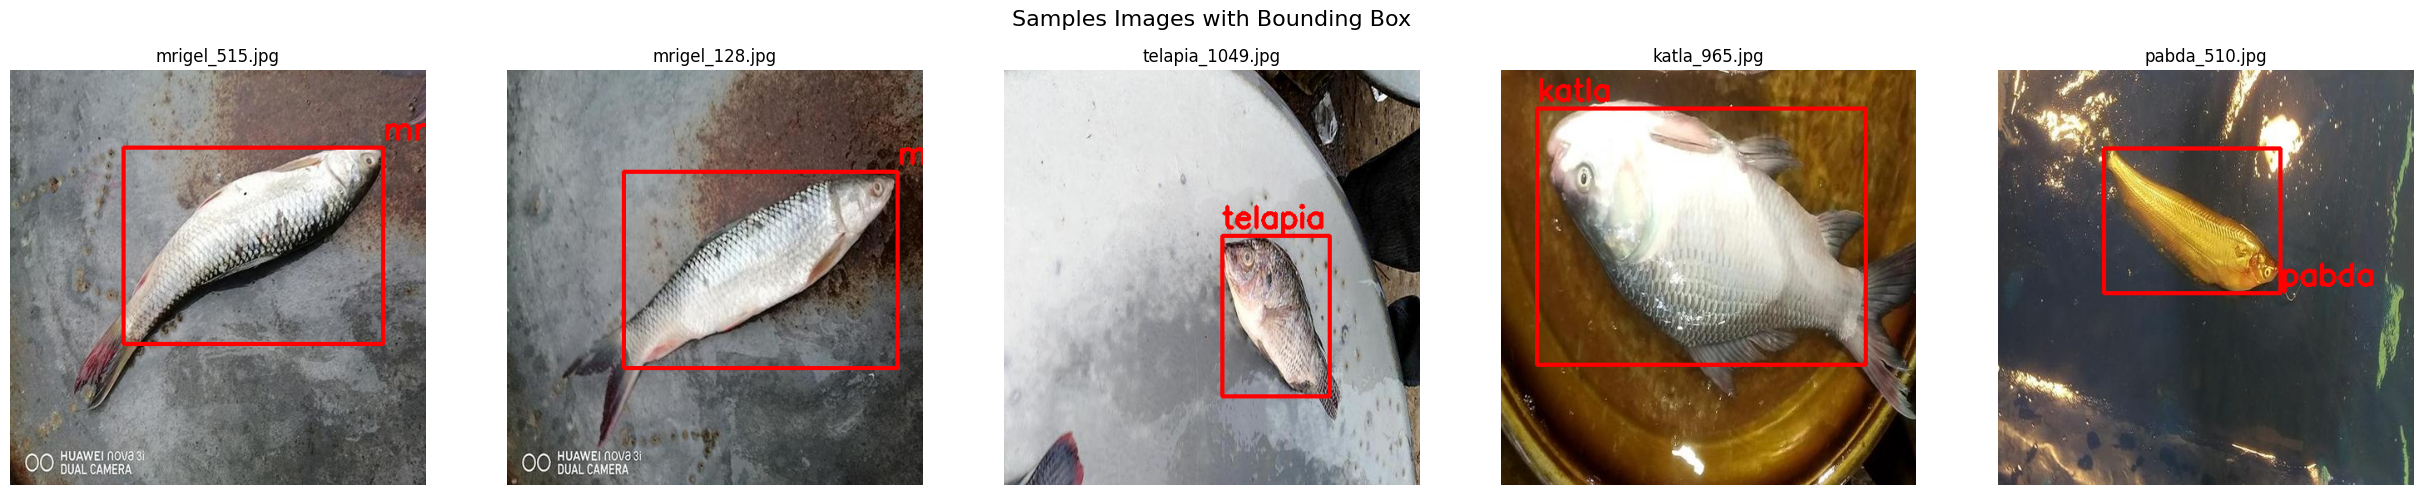

In [4]:
train_images_path = '/kaggle/working/SylFishBD-YOLO/images/train/'
image_files = os.listdir(train_images_path)

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Samples Images with Bounding Box', fontsize=16)

for i in range(5):
    random_image_name = random.choice(image_files)
    image_path = os.path.join(train_images_path, random_image_name)
    label_path = image_path.replace('/images/', '/labels/').replace('.jpg', '.txt')

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        line = f.readline().strip().split()
        class_index = int(line[0])
        x_center_norm, y_center_norm, width_norm, height_norm = map(float, line[1:])

    x_center = x_center_norm * w
    y_center = y_center_norm * h
    box_width = width_norm * w
    box_height = height_norm * h
    x_min = int(x_center - (box_width / 2))
    y_min = int(y_center - (box_height / 2))
    x_max = int(x_center + (box_width / 2))
    y_max = int(y_center + (box_height / 2))

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)
    class_name = class_names[class_index]
    cv2.putText(image, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 3)

    axes[i].imshow(image)
    axes[i].set_title(random_image_name)
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# YOLO Model Training

In [5]:
from ultralytics import YOLO

device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: 0


## Training YOLOv10 Model

In [6]:
model_v10 = YOLO('yolov10n.pt')

results_v10 = model_v10.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    batch=16,
    imgsz=640,
    project='/kaggle/working/training_runs',
    name='yolov10_train',
    exist_ok=True
)

print("\nYOLOv10 training complete.")

Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

## Training YOLOv11 Model

In [7]:
yolo11_model_path = '/kaggle/input/yolo-v11-v12/yolo11n.pt' 

model_v11 = YOLO(yolo11_model_path)

results_v11 = model_v11.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    batch=16,
    imgsz=640,
    project='/kaggle/working/training_runs',
    name='yolov11_train',
    exist_ok=True
)

print("\nYOLOv11 training complete.")

Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolo-v11-v12/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pers

## Training YOLOv12 Model

In [8]:
yolo12_model_path = '/kaggle/input/yolo-v11-v12/yolov12n.pt' 

model_v12 = YOLO(yolo12_model_path)

results_v12 = model_v12.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    batch=16,
    imgsz=640,
    project='/kaggle/working/training_runs',
    name='yolov12_train',
    exist_ok=True
)

print("\nYOLOv12 training complete.")

Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolo-v11-v12/yolov12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov12_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, per

## Save weights and logs

In [9]:
path_v10_best = '/kaggle/working/training_runs/yolov10_train/weights/best.pt'
path_v11_best = '/kaggle/working/training_runs/yolov11_train/weights/best.pt'
path_v12_best = '/kaggle/working/training_runs/yolov12_train/weights/best.pt'

# Load YOLOv10
if os.path.exists(path_v10_best):
    model_v10_best = YOLO(path_v10_best)
    print("Successfully loaded best weights for YOLOv10.")
else:
    model_v10_best = None
    print("Could not find best weights for YOLOv10.")

# Load YOLOv11
if os.path.exists(path_v11_best):
    model_v11_best = YOLO(path_v11_best)
    print("Successfully loaded best weights for YOLOv11.")
else:
    model_v11_best = None
    print("Could not find best weights for YOLOv11.")

# Load YOLOv12
if os.path.exists(path_v12_best):
    model_v12_best = YOLO(path_v12_best)
    print("Successfully loaded best weights for YOLOv12.")
else:
    model_v12_best = None
    print("Could not find best weights for YOLOv12.")

Successfully loaded best weights for YOLOv10.
Successfully loaded best weights for YOLOv11.
Successfully loaded best weights for YOLOv12.


# Evaluation & Comparison

## Training and validation loss/mAP curves


YOLOv10 Training Results


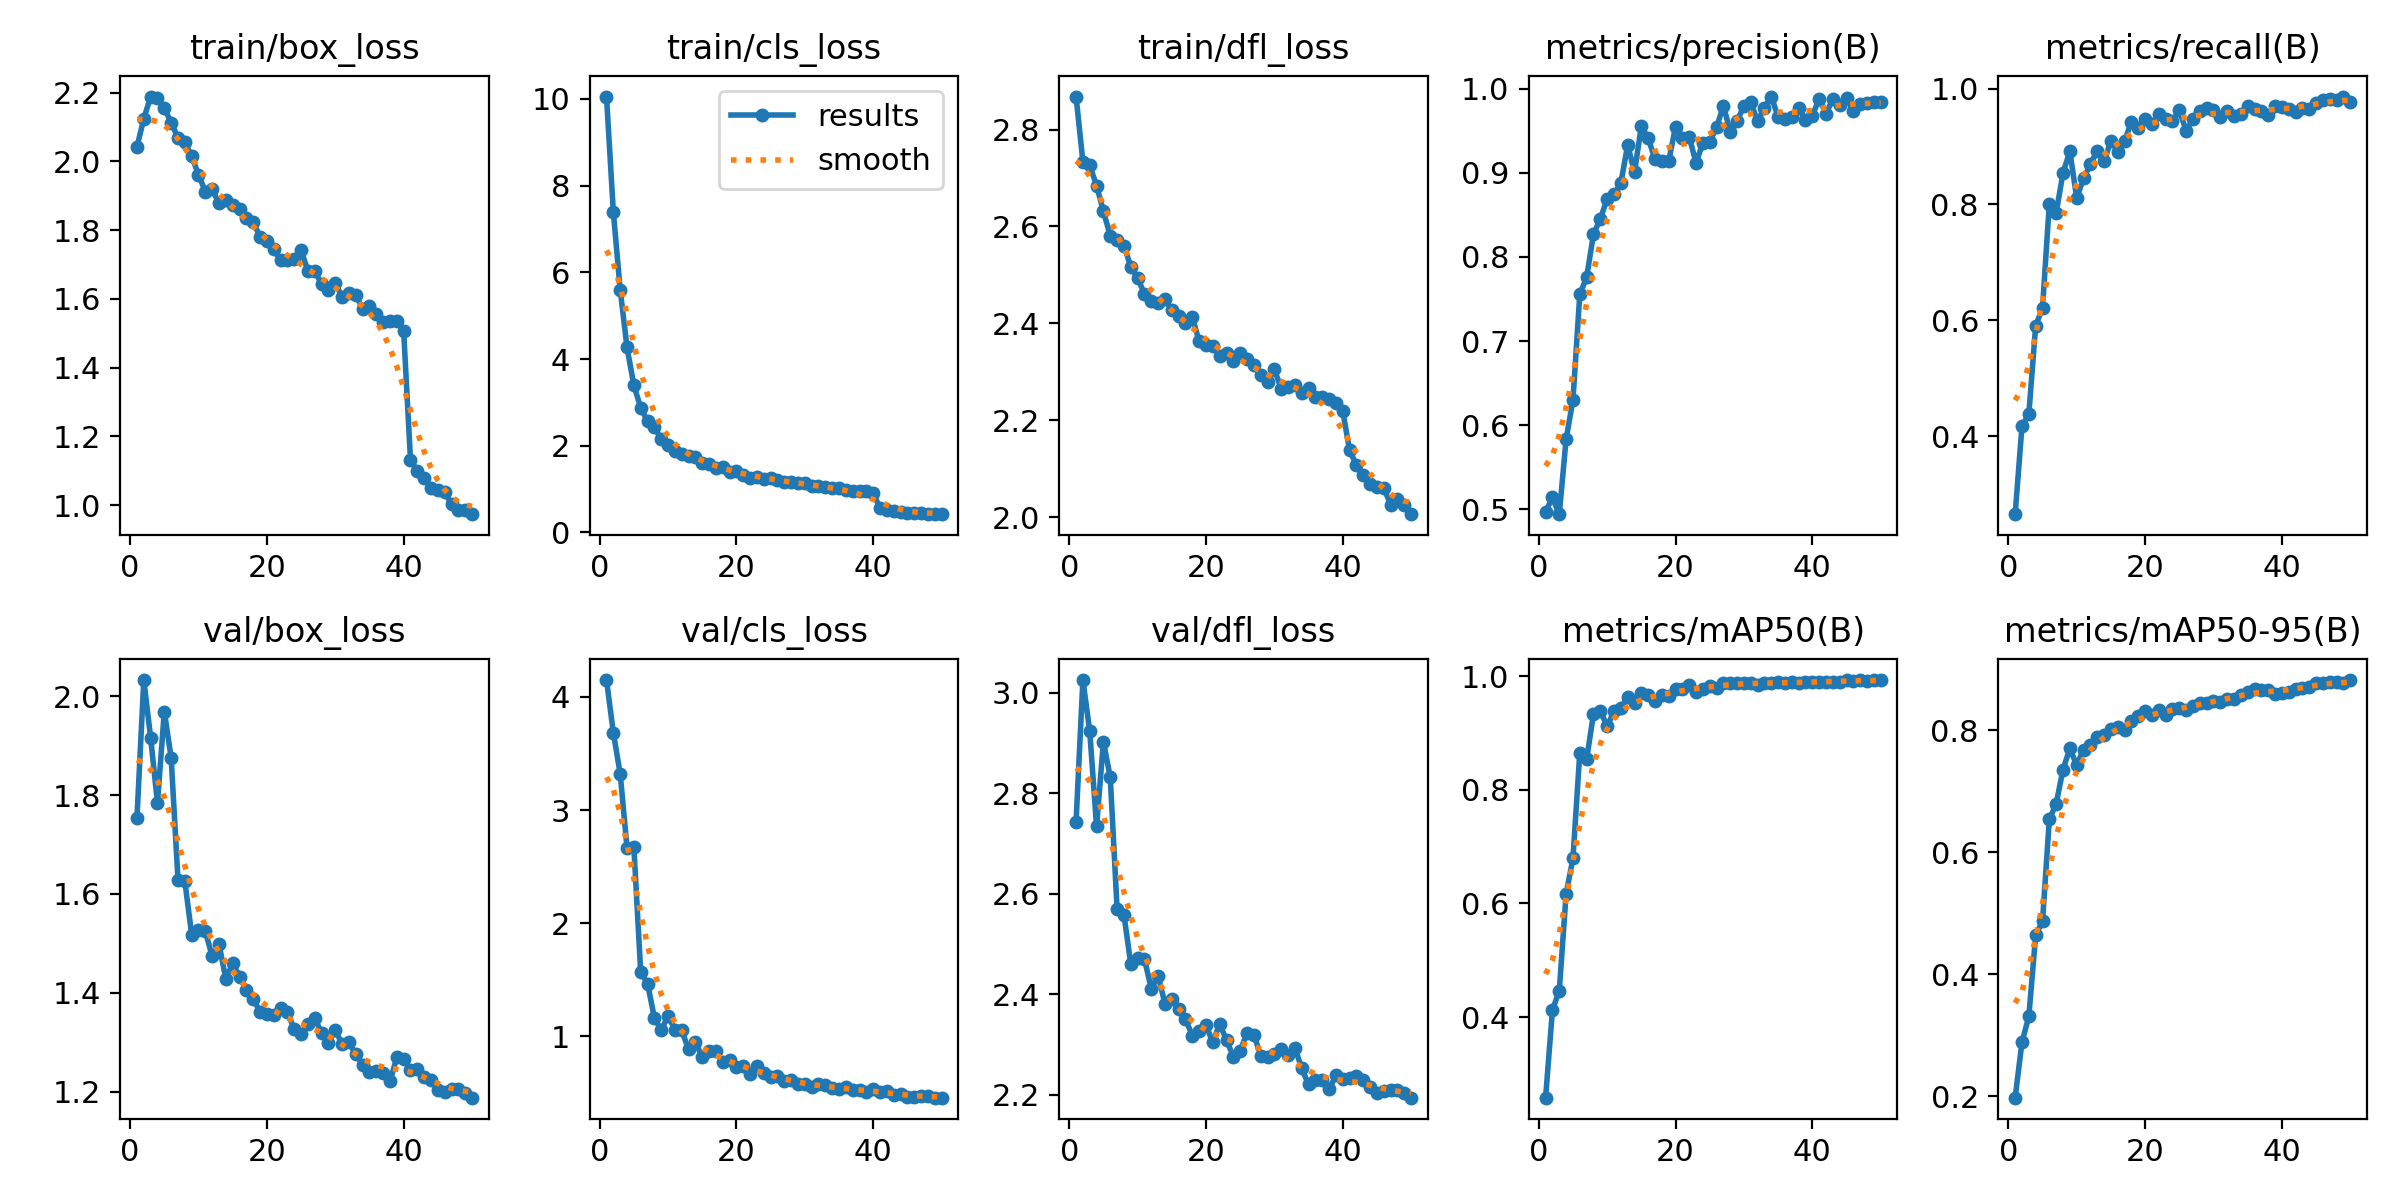


YOLOv11 Training Results


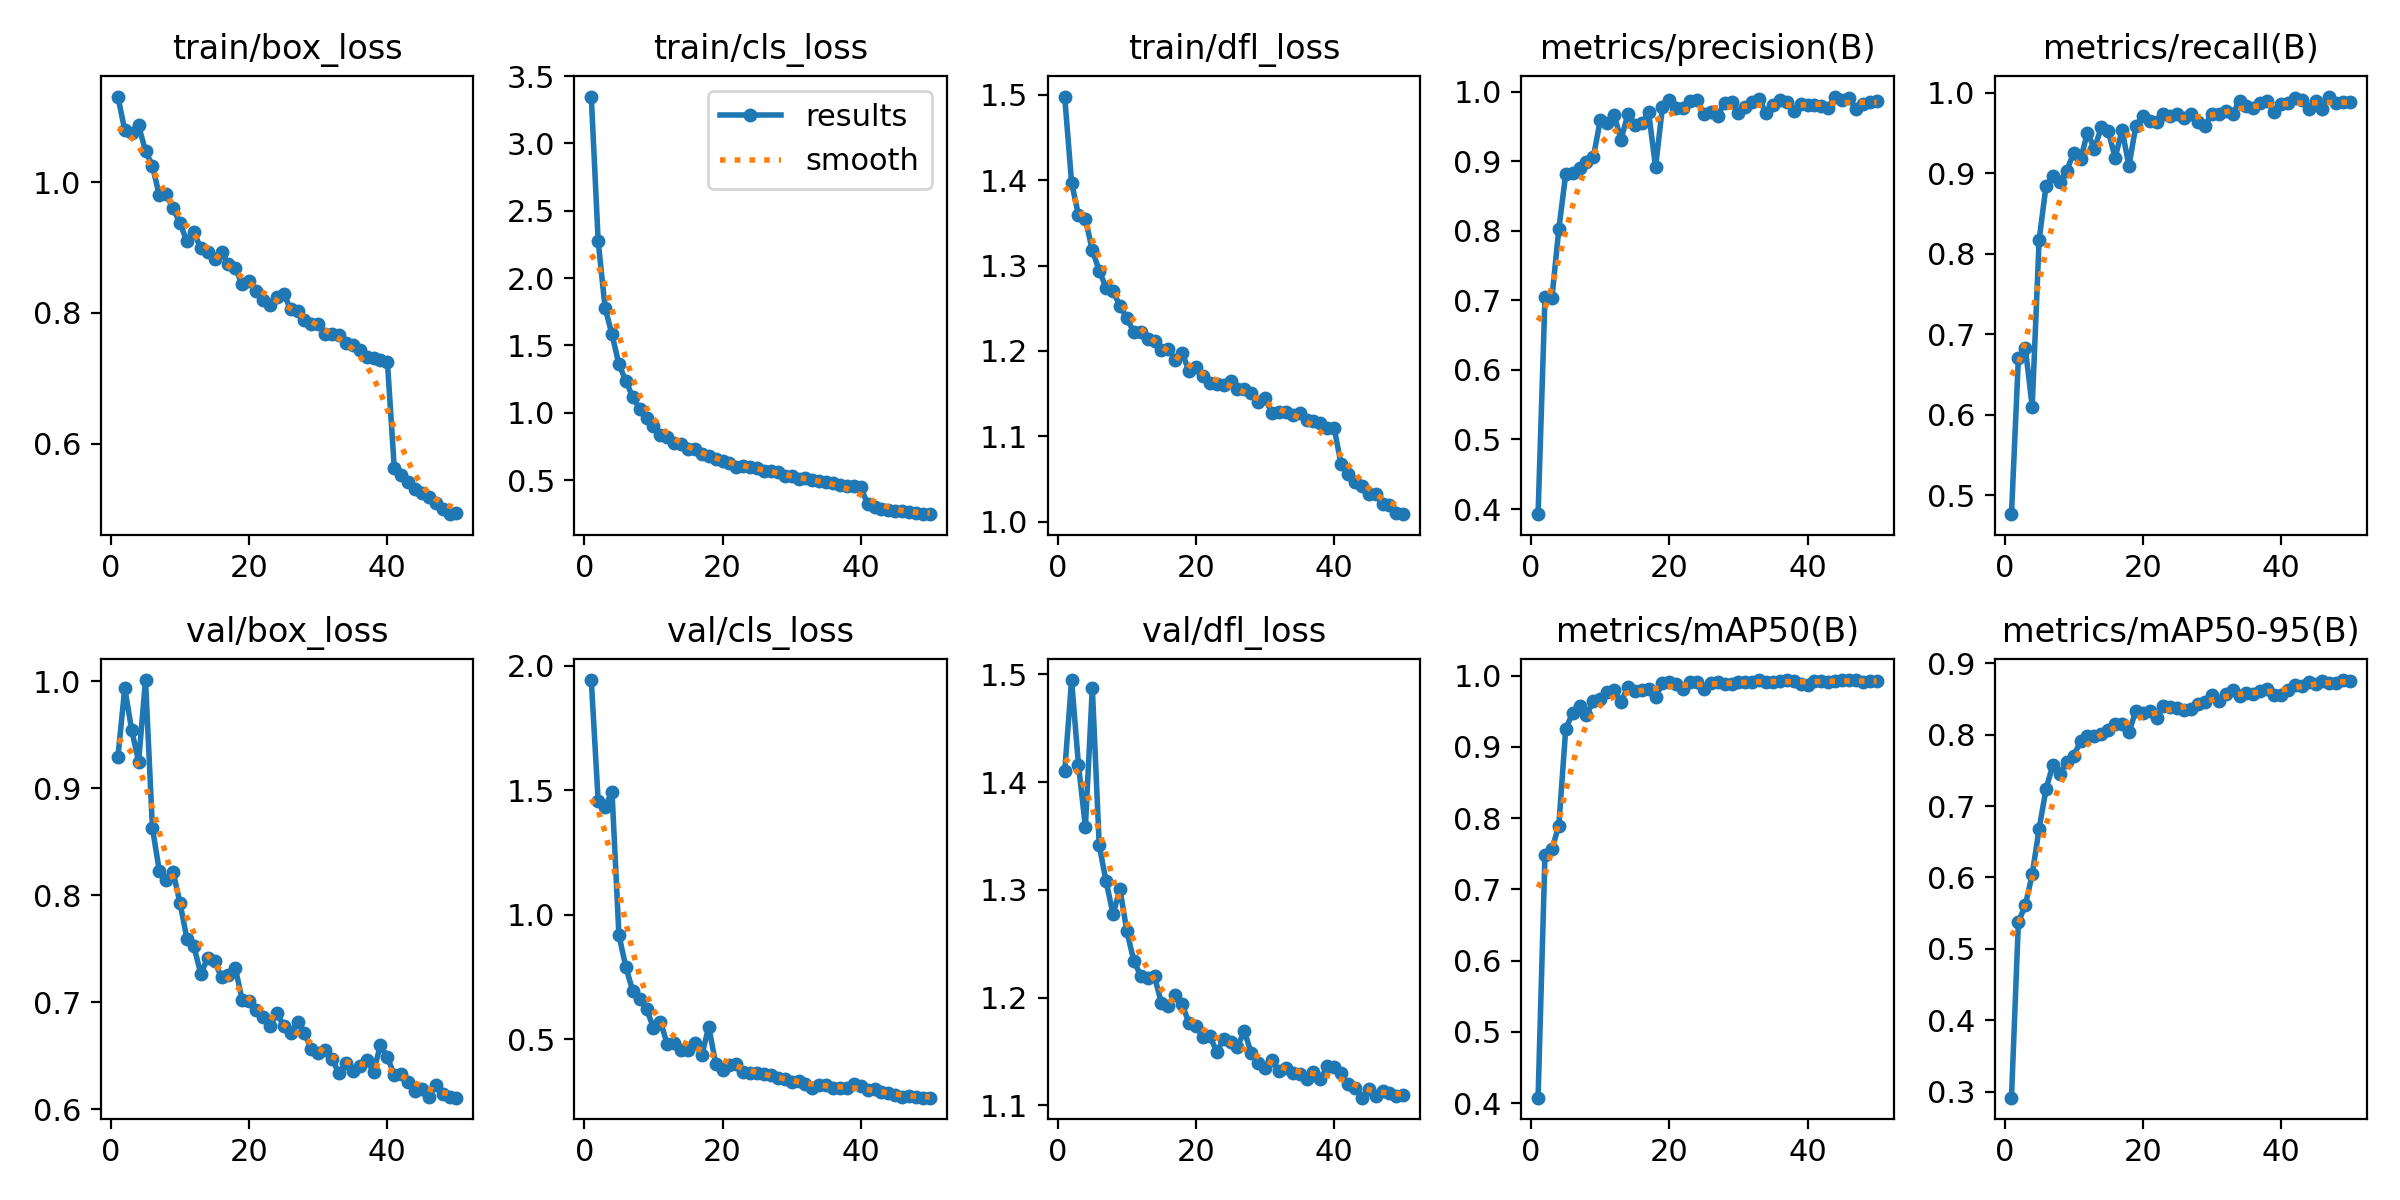


YOLOv12 Training Results


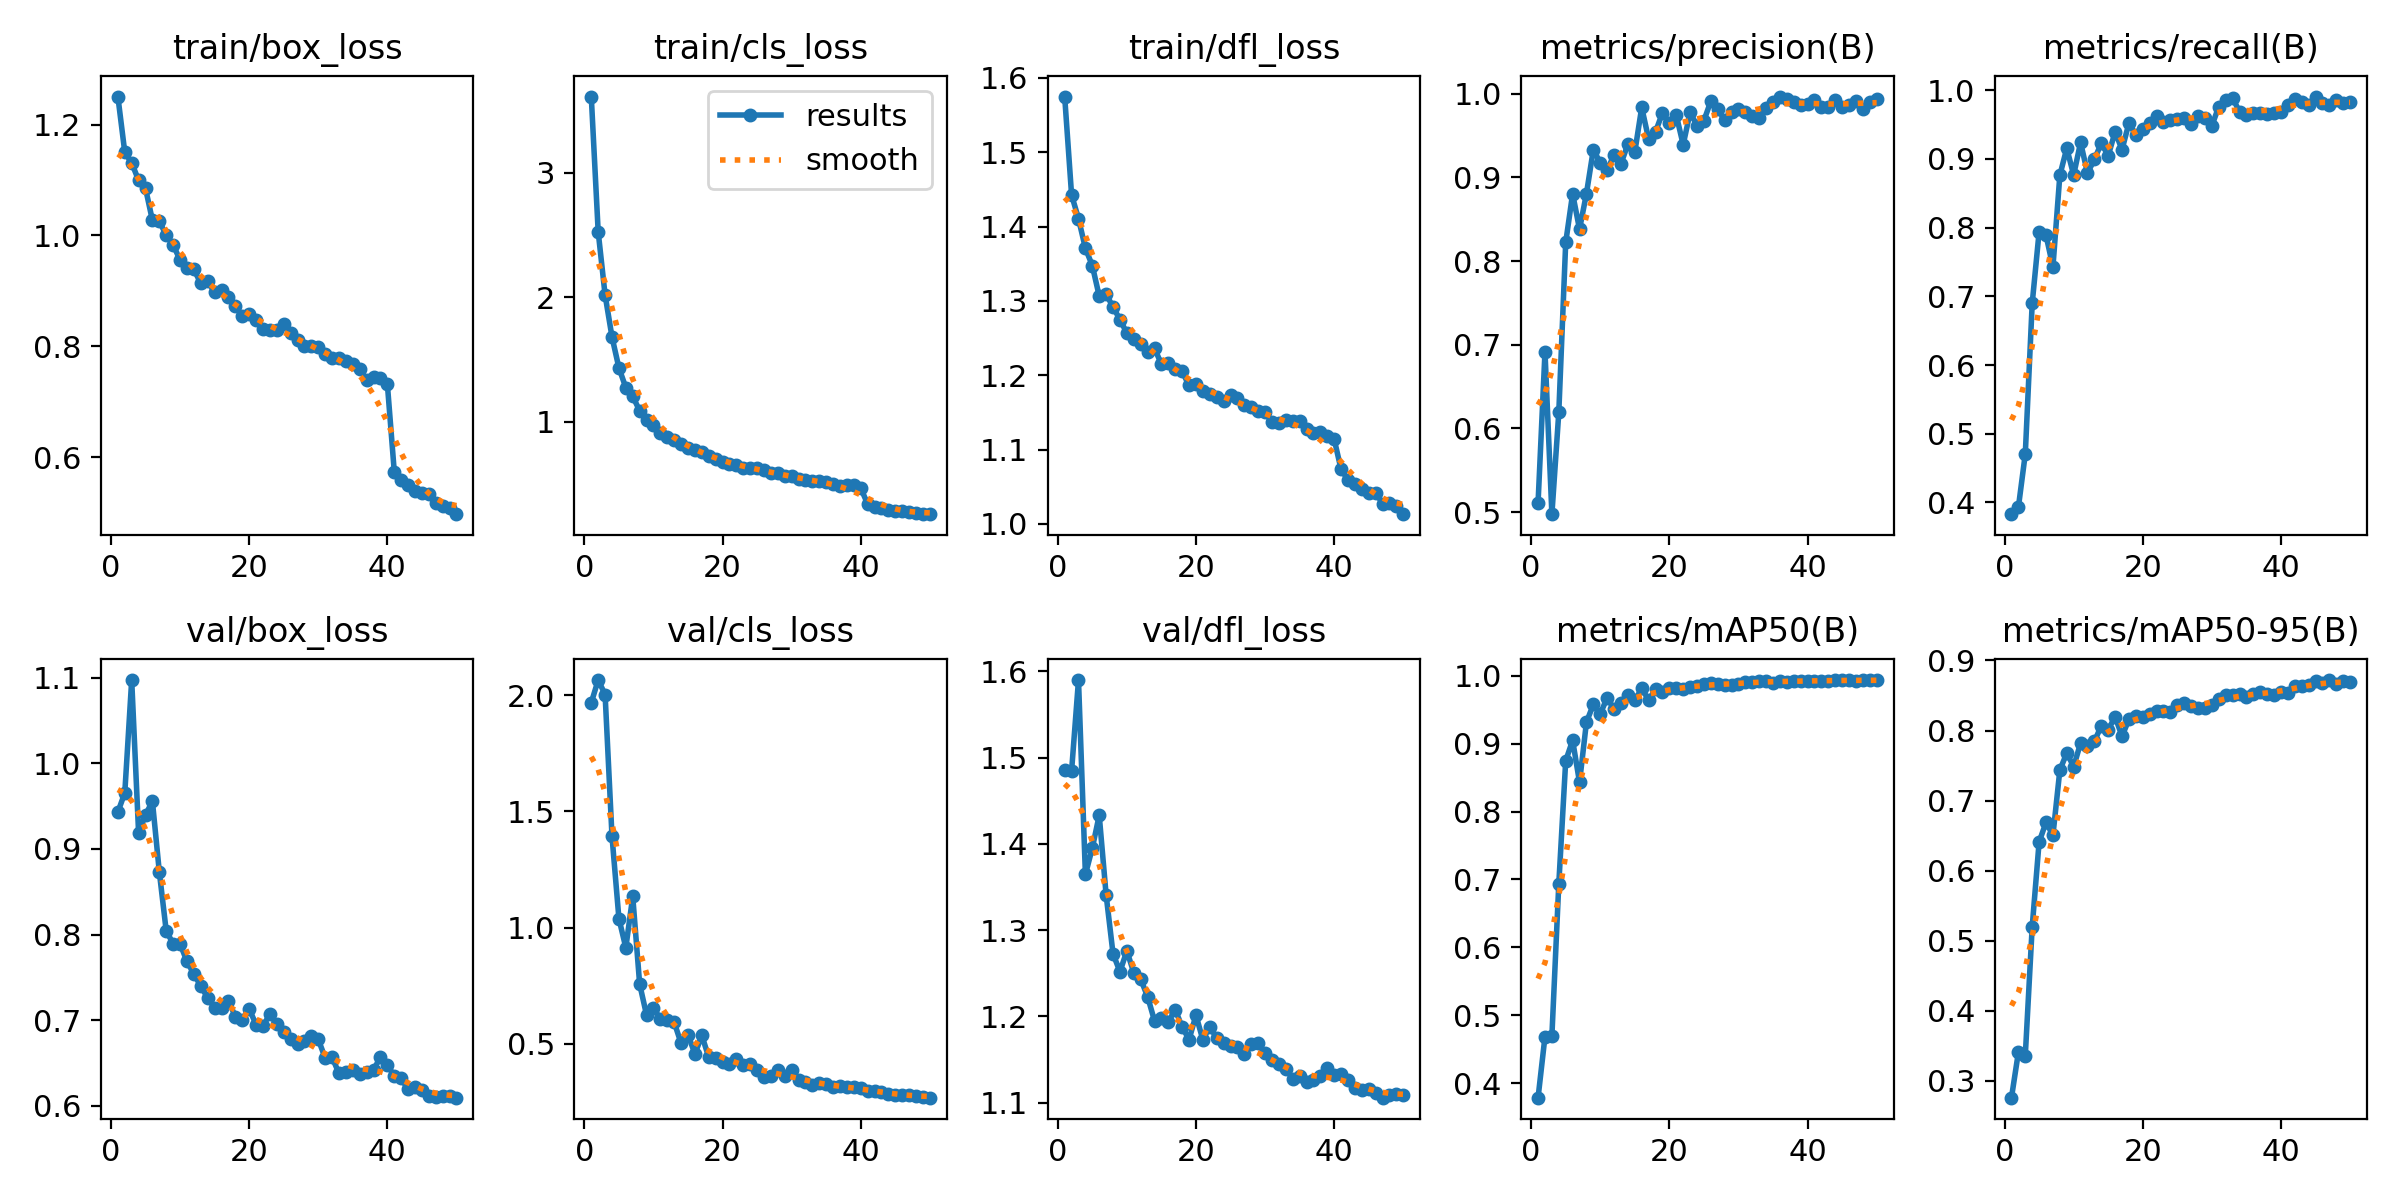

In [10]:
yolov10_results_path = '/kaggle/working/training_runs/yolov10_train/results.png'
if os.path.exists(yolov10_results_path):
    print("\nYOLOv10 Training Results")
    display(Image(filename=yolov10_results_path, width=900))
else:
    print("\nCould not find results image for YOLOv10.")

yolov11_results_path = '/kaggle/working/training_runs/yolov11_train/results.png'
if os.path.exists(yolov11_results_path):
    print("\nYOLOv11 Training Results")
    display(Image(filename=yolov11_results_path, width=900))
else:
    print("\nCould not find results image for YOLOv11.")

yolov12_results_path = '/kaggle/working/training_runs/yolov12_train/results.png'
if os.path.exists(yolov12_results_path):
    print("\nYOLOv12 Training Results")
    display(Image(filename=yolov12_results_path, width=900))
else:
    print("\nCould not find results image for YOLOv12.")

## Evaluation of All Model on the Test Set

In [11]:
if model_v10_best:
    metrics_v10 = model_v10_best.val(
        data='/kaggle/working/data.yaml',
        split='test',
        project='/kaggle/working/validation_runs',
        name='yolov10_eval',
        exist_ok=True
    )
    print("YOLOv10 evaluation complete.")

if model_v11_best:
    metrics_v11 = model_v11_best.val(
        data='/kaggle/working/data.yaml',
        split='test',
        project='/kaggle/working/validation_runs',
        name='yolov11_eval',
        exist_ok=True
    )
    print("YOLOv11 evaluation complete.")

if model_v12_best:
    metrics_v12 = model_v12_best.val(
        data='/kaggle/working/data.yaml',
        split='test',
        project='/kaggle/working/validation_runs',
        name='yolov12_eval',
        exist_ok=True
    )
    print("YOLOv12 evaluation complete.")

Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,266,923 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1232.1±348.8 MB/s, size: 52.3 KB)
val: Scanning /kaggle/working/SylFishBD-YOLO/labels/test... 1362 images, 0 backgrounds, 864 corrupt: 100% ━━━━━━━━━━━━ 1362/1362 1.6Kit/s 0.8s
val: /kaggle/working/SylFishBD-YOLO/images/test/boal_014.jpg: ignoring corrupt image/label: negative class labels or coordinate [   -0.65275]
val: /kaggle/working/SylFishBD-YOLO/images/test/boal_022.jpg: ignoring corrupt image/label: negative class labels or coordinate [    -0.6978]
val: /kaggle/working/SylFishBD-YOLO/images/test/boal_033.jpg: ignoring corrupt image/label: negative class labels or coordinate [   -0.55385]
val: /kaggle/working/SylFishBD-YOLO/images/test/boal_065.jpg: ignoring corrupt image/label: negative class labels or coordinate [   -0.58571]
val: /kaggle/working/SylFishBD-YOLO/images/test/bo

## Comparison Table of Report Metrics

In [12]:
results_list = []

def calculate_f1(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

if model_v10_best:
    p10 = metrics_v10.box.p[0]
    r10 = metrics_v10.box.r[0]
    results_list.append({
        "Model": "YOLOv10",
        "mAP@0.5": metrics_v10.box.map50,
        "mAP@0.5:0.95": metrics_v10.box.map,
        "Precision": p10,
        "Recall": r10,
        "F1 Score": calculate_f1(p10, r10)
    })

if model_v11_best:
    p11 = metrics_v11.box.p[0]
    r11 = metrics_v11.box.r[0]
    results_list.append({
        "Model": "YOLOv11",
        "mAP@0.5": metrics_v11.box.map50,
        "mAP@0.5:0.95": metrics_v11.box.map,
        "Precision": p11,
        "Recall": r11,
        "F1 Score": calculate_f1(p11, r11)
    })
    
if model_v12_best:
    p12 = metrics_v12.box.p[0]
    r12 = metrics_v12.box.r[0]
    results_list.append({
        "Model": "YOLOv12",
        "mAP@0.5": metrics_v12.box.map50,
        "mAP@0.5:0.95": metrics_v12.box.map,
        "Precision": p12,
        "Recall": r12,
        "F1 Score": calculate_f1(p12, r12)
    })

if results_list:
    df_results = pd.DataFrame(results_list).set_index('Model')
    
    print("\nComparison Table")
    display(df_results.style.format({
        "mAP@0.5": '{:.4f}',
        "mAP@0.5:0.95": '{:.4f}',
        "Precision": '{:.4f}',
        "Recall": '{:.4f}',
        "F1 Score": '{:.4f}'
    }))
else:
    print("No evaluation results to display.")


Comparison Table


# Visualization and Explainability

## Five random predictions with bounding boxes and confidence scores


Best model selected: YOLOv11 with mAP@0.5:0.95 of 0.8753
Predictions with YOLOv11 on 5 random test images

0: 640x640 1 mrigel, 10.2ms
1: 640x640 1 rui, 10.2ms
2: 640x640 1 ilish, 10.2ms
3: 640x640 1 rui, 10.2ms
4: 640x640 1 telapia, 10.2ms
Speed: 3.4ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/runs/detect/predict
Prediction results saved in: /kaggle/working/runs/detect/predict

Prediction Results


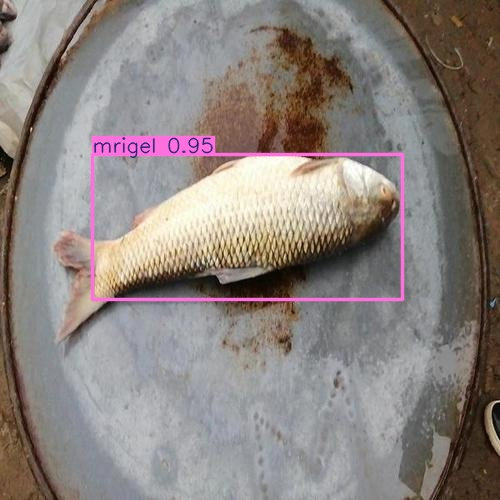

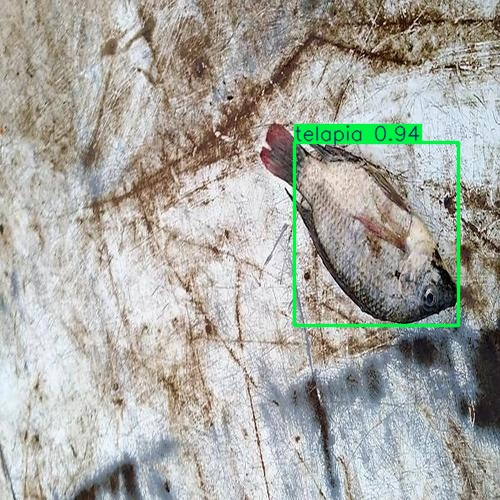

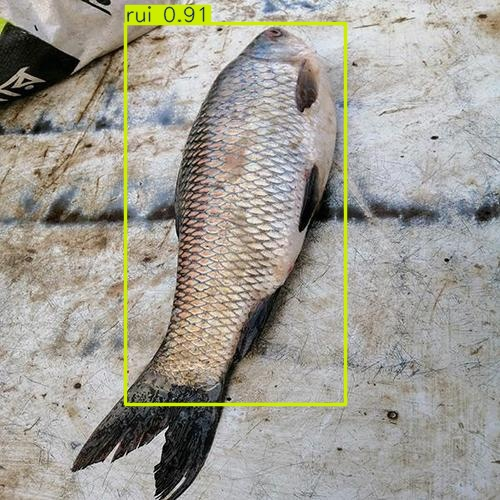

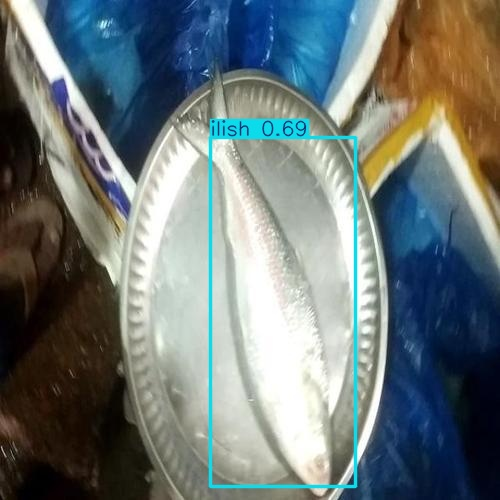

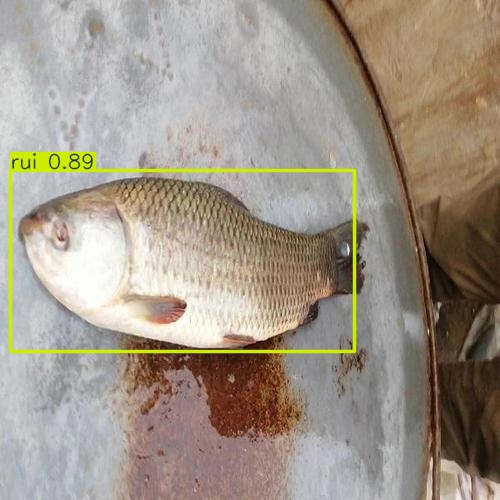

In [13]:
evaluated_models = []

if 'metrics_v10' in locals() and model_v10_best:
    evaluated_models.append({
        'name': 'YOLOv10',
        'map_score': metrics_v10.box.map,
        'path': path_v10_best
    })

if 'metrics_v11' in locals() and model_v11_best:
    evaluated_models.append({
        'name': 'YOLOv11',
        'map_score': metrics_v11.box.map,
        'path': path_v11_best
    })

if 'metrics_v12' in locals() and model_v12_best:
    evaluated_models.append({
        'name': 'YOLOv12',
        'map_score': metrics_v12.box.map,
        'path': path_v12_best
    })

best_model_path = None
best_model_name = "None"

if not evaluated_models:
    print("WARNING: No models were successfully evaluated")
else:
    best_model_info = sorted(evaluated_models, key=lambda x: x['map_score'], reverse=True)[0]
    
    best_model_path = best_model_info['path']
    best_model_name = best_model_info['name']
    
    print(f"\nBest model selected: {best_model_name} with mAP@0.5:0.95 of {best_model_info['map_score']:.4f}")


if best_model_path and os.path.exists(best_model_path):
    model_best = YOLO(best_model_path)
    
    test_images_dir = '/kaggle/working/SylFishBD-YOLO/images/test'
    random_test_images = random.sample(os.listdir(test_images_dir), 5)
    image_paths_to_predict = [os.path.join(test_images_dir, img) for img in random_test_images]
    
    print(f"Predictions with {best_model_name} on 5 random test images")
    predict_results = model_best.predict(
        source=image_paths_to_predict,
        conf=0.30, 
        save=True
    )
    print(f"Prediction results saved in: {predict_results[0].save_dir}")

    print("\nPrediction Results")
    predicted_image_files = os.listdir(predict_results[0].save_dir)
    for img_file in predicted_image_files:
        display(Image(filename=os.path.join(predict_results[0].save_dir, img_file)))
        
else:
    print("Skipping prediction visualization because a best model could not be found or its weight file is missing.")

## Grad-CAM or heatmap visualization for interpretability

In [14]:
!git clone https://github.com/rigvedrs/YOLO-V12-CAM.git
%cd /kaggle/working/YOLO-V12-CAM

!pip install ttach -q
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image
%cd /kaggle/working/

Cloning into 'YOLO-V12-CAM'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 168 (delta 39), reused 21 (delta 11), pack-reused 99 (from 2)
Receiving objects: 100% (168/168), 52.67 MiB | 39.57 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/kaggle/working/YOLO-V12-CAM
/kaggle/working



Loading the best model for CAM analysis: /kaggle/working/training_runs/yolov11_train/weights/best.pt
Analyzing image: boal_244.jpg

0: 640x640 1 boal, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

Displaying Eigen-CAM Result:


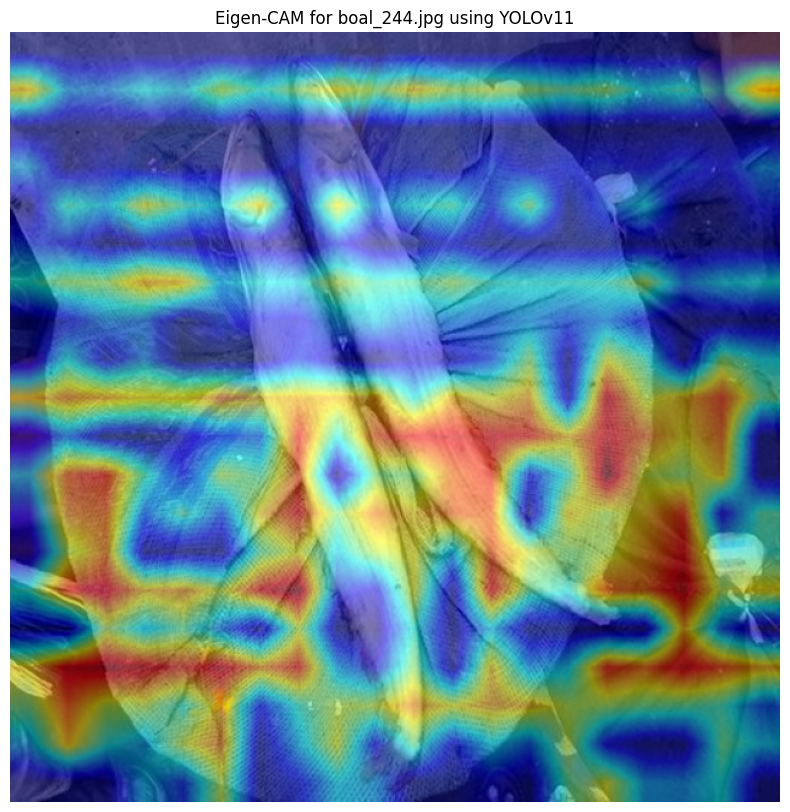

In [15]:
if best_model_path and os.path.exists(best_model_path):
    print(f"\nLoading the best model for CAM analysis: {best_model_path}")
    model_cam = YOLO(best_model_path)
    
    image_dir = '/kaggle/working/SylFishBD-YOLO/images/test'
    image_name = random.choice(os.listdir(image_dir))
    image_to_analyze_path = os.path.join(image_dir, image_name)
    print(f"Analyzing image: {image_name}")
    target_layers = [model_cam.model.model[-2]] 

    rgb_img = cv2.imread(image_to_analyze_path)
    rgb_img = cv2.resize(rgb_img, (640, 640))
    img_for_overlay = np.float32(rgb_img) / 255
    cam = EigenCAM(model_cam, target_layers, task='od')
    grayscale_cam = cam(rgb_img)[0, :, :]
    cam_image = show_cam_on_image(img_for_overlay, grayscale_cam, use_rgb=True)

    print("\nDisplaying Eigen-CAM Result:")
    plt.figure(figsize=(10, 10))
    plt.imshow(cam_image)
    plt.axis('off')
    plt.title(f"Eigen-CAM for {image_name} using {best_model_name}")
    plt.show()

else:
    print("Skipping CAM visualization because a best model could not be found.")

# Final Report Summary: Object Detection and Model Comparison using YOLOv10, v11, and v12
This report summarizes the process and findings of the CSE 475 Machine Learning assignment. The objective was to train, evaluate, and compare three different YOLO object detection models on a custom dataset, culminating in a detailed analysis of their performance and behavior.

## **1. Dataset Overview**

The project utilized the SylFishBD: A Freshwater Fish Dataset, a collection of 9,075 annotated images captured in real-world market conditions in Sylhet, Bangladesh.

Key Characteristics:

Classes: The dataset contains 9 distinct species of freshwater fish: boal, ilish, kalibaush, katla, koi, mrigel, pabda, rui, and telapia.

Image Properties: All images are 500x500 pixels in RGB format. The dataset is notable for its high-quality, single-instance annotations and challenging real-world settings, which include cluttered backgrounds, varied lighting, and occlusions.

Annotation Format: The original annotations were provided in a nested COCO-style JSON format.

Data Preparation Pipeline:
A critical preparatory step was to convert the dataset into a format compatible with the YOLO training framework. The following actions were performed:

Data Splitting: The dataset was partitioned into training (70%), validation (15%), and testing (15%) sets to ensure a robust and unbiased evaluation.

Annotation Conversion: A Python script was developed to parse the original JSON files, extract the bounding box coordinates ([[x_min, y_min], [x_max, y_max]]), and convert them into the required YOLO .txt format (<class_index> <x_center_norm> <y_center_norm> <width_norm> <height_norm>).

YAML Configuration: A data.yaml file was created to define the paths to the train/val/test sets and to map the class indices to their respective names.

## **2. Model Setup Summary**

Models Trained: Three nano-scale YOLO variants were trained and compared

YOLOv10n

YOLOv11n

YOLOv12n

Methodology: Transfer Learning
The core training strategy was transfer learning. Instead of training the models from scratch, pre-trained weights were used as a starting point. These models, having been pre-trained on large-scale datasets like COCO, already possess a strong foundational understanding of visual features. This approach significantly accelerates training and leads to superior performance, especially on specialized datasets like SylFishBD.

Consistent Hyperparameters:
To ensure a fair and direct comparison, all three models were trained using an identical set of hyperparameters.
Hyperparameter	Value
Epochs	50
Batch Size	16
Input Image Size	640x640
Optimizer	Auto (AdamW selected by framework)

Environment:
All training and evaluation tasks were conducted within the Kaggle Notebooks environment, utilizing a Tesla T4 GPU accelerator to ensure efficient computation. All weights and training logs were saved to the /kaggle/working/training_runs/ directory as required.

## **3. Evaluation Results**

After training, each model's best-performing checkpoint (best.pt) was evaluated on the unseen test set. The key performance metrics are summarized in the table below, providing a direct comparison of their effectiveness on the fish detection task.

Model        mAP@0.5	       mAP@0.5:0.95	        Precision	       Recall	       F1 Score

YOLOv10n	 0.9859	           0.8696	            0.9372	           0.8960	       0.9162

YOLOv11n	0.9847	           0.8753	            0.9781	           0.8935	       0.9339

YOLOv12n	0.9844	           0.8713	            0.9775	           0.9400	       0.9584

## **4. Key Observations and Conclusion**

**Overall Performance:**
All three models achieved exceptionally high performance, with mAP@0.5 scores nearing 98.5%. This demonstrates that modern YOLO architectures are extremely effective for this fish detection task. The healthy training curves and successful CAM visualization confirm that the models learned robust and relevant features.

**Best Performing Model:**
Based on the primary industry-standard metric, mAP@0.5:0.95, the YOLOv11 model emerged as the top performer with a score of 0.8753. This metric considers accuracy across a range of overlap thresholds, making it a more comprehensive measure of bounding box precision.

Interestingly, while YOLOv11 was the best on the primary mAP metric, YOLOv12 achieved the highest F1 Score (0.9584), indicating it had the best balance between precision (not making false detections) and recall (finding all actual fish).

**Interpretability (CAM Analysis):**
The Eigen-CAM visualization performed on the YOLOv11 model was highly insightful. The heatmap showed strong activation directly on the fish's body, confirming that the model correctly focused on the object of interest while ignoring irrelevant background elements like watermarks. This provides high confidence in the model's decision-making process.

**Conclusion:**
This project successfully demonstrated the end-to-end process of fine-tuning and comparing state-of-the-art object detectors. For a scenario demanding the absolute best bounding box placement across multiple thresholds, YOLOv11 is the recommended model. However, if the goal is to maximize the balance of finding all fish while minimizing false alarms, YOLOv12 would be the superior choice due to its higher F1 Score.